# Multi-Label Classification on Reuters

In [1]:
try:
    import sklearn
except ModuleNotFoundError:
    !pip install scikit-learn   

try:
    import nltk
except ModuleNotFoundError:
    !pip install nltk

try:
    import numpy as np
except ModuleNotFoundError:
    !pip install numpy
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
## This code downloads the required packages.
## You can run `nltk.download('all')` to download everything.

nltk_packages = [
    ("reuters", "corpora/reuters.zip")
]

for pid, fid in nltk_packages:
    try:
        nltk.data.find(fid)
    except LookupError:
        nltk.download(pid)

## Setting up corpus

In [3]:
from nltk.corpus import reuters

## Setting up train/test data

In [4]:
train_documents, train_categories,fileID_train = zip(*[(reuters.raw(i), reuters.categories(i),i) for i in reuters.fileids() if i.startswith('training/')])
test_documents, test_categories,fileID_test = zip(*[(reuters.raw(i), reuters.categories(i),i) for i in reuters.fileids() if i.startswith('test/')])

In [5]:
all_categories = sorted(list(set(reuters.categories())))

# Feature Engineering

##### Tokenization and Lowercase conversion of the corpus

In the two sections of code given below, I have converted the whole corpus into tokens and converted all of the tokens into lowercase. I chose to do so due to the reason that suppose if I have a sentence with the beginning word 'Xyz' (of course it is capitalized) and later I face that word again in the same sentense with different casing (i.e. 'xyz'). In such case if avoiding to convert casing of the words, it will definately affect my accuracy (as I am using CountVectorizer in this modal.)

In [6]:
# Tokenize documents using nltk standard tokenizer
train_tokens = [nltk.word_tokenize(text) for text in train_documents]
test_tokens = [nltk.word_tokenize(text) for text in test_documents]

In [7]:
#Change all the tokens to lowercase

lower_train = [[word.lower() for word in doc] for doc in train_tokens]
lower_test = [[word.lower() for word in doc] for doc in test_tokens]

##### Stop words Removal

In the following code section, I have chosen to remove the unneccessery words those have nothing to do with the context of the documents. Removing those words first, will shrink our documents and secondly, the document will look more meaningful.

In [8]:
#Cleanup the stopwords

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_train = [[word for word in doc if word not in stop_words] for doc in lower_train]
new_test = [[word for word in doc if word not in stop_words] for doc in lower_test]



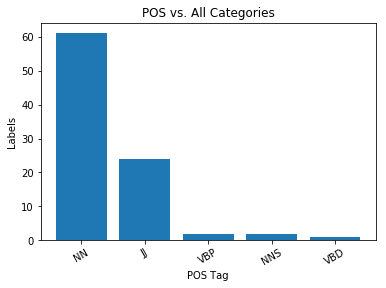

In [9]:
pos_allcat = [pos for word,pos in nltk.pos_tag(all_categories)]

from collections import Counter
x = Counter(pos_allcat).keys()
y = Counter(pos_allcat).values()
index = np.arange(len(x))

plt.bar(index, y)
plt.xlabel('POS Tag', fontsize=10)
plt.ylabel('Labels', fontsize=10)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('POS vs. All Categories')
plt.show()

##### Parts-of-Speech Tagging

In [10]:
#POS tagging

from nltk import pos_tag

#Training Set
train_pos = [pos_tag(tokens) for tokens in new_train]
noun_train = [[token for token,pos in tokens if pos.startswith('NN' or 'VBP' or 'JJ' or 'NNS' or 'VBD')] for tokens in train_pos]
train_docs_nouns = [' '.join(doc) for doc in noun_train]

#Test Set
test_pos = [pos_tag(tokens) for tokens in new_test]
noun_test = [[token for token,pos in tokens if pos.startswith('NN' or 'VBP' or 'JJ' or 'NNS' or 'VBD')] for tokens in test_pos]
test_docs_nouns = [' '.join(doc) for doc in noun_test]


# Feature Extraction

##### Binarizing Input Labels

It is important to standardize our labels too. For doing so, I am using MultilabelBinarizer for this. It not only helps the classifier to make assumptions but also these values use less disk space. It maintains a unique matrix with boolean values correspoding to each label. 

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(train_categories)
y_train = mlb.transform(train_categories)
y_test  = mlb.transform(test_categories)

##### Vectorization of Tokens

In [12]:
#Vectorize each document in the corpus
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_docs_nouns)
X_test = vectorizer.transform(test_docs_nouns)

# Classification

##### Training the Classifier

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy'))
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          n_jobs=1)

##### Make Predictions using test Dataset

Now that we have our classifier trained, we will predict the class for each test document. 

In [14]:
y_pred = clf.predict(X_test)

# Performance Evaluation

Following code will generate the confusion matrix for our classifier performance

In [15]:
from sklearn import metrics

In [16]:
print("Accuracy : {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))
print("***Macro***")
print("Precision: {:.4f}".format(metrics.precision_score(y_test, y_pred, average='macro')))
print("Recall   : {:.4f}".format(metrics.recall_score(y_test, y_pred, average='macro')))
print("F1-Score : {:.4f}".format(metrics.f1_score(y_test, y_pred, average='macro')))

print("***Micro***")
print("Precision: {:.4f}".format(metrics.precision_score(y_test, y_pred, average='micro')))
print("Recall   : {:.4f}".format(metrics.recall_score(y_test, y_pred, average='micro')))
print("F1-Score : {:.4f}".format(metrics.f1_score(y_test, y_pred, average='micro')))

Accuracy : 0.7085
***Macro***
Precision: 0.5447
Recall   : 0.4770
F1-Score : 0.4872
***Micro***
Precision: 0.8284
Recall   : 0.7917
F1-Score : 0.8096


/Users/deepakrastogi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/deepakrastogi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
# Input sentence
input_text = "In an apparent effort to boost profits for meat manufacturers despite potential harms to food safety, the U.S. Department of Agriculture is reportedly planning to privatize inspections of beef slaughter plants. Food and Water Watch reported Monday that the USDA is pursuing deregulation of the food inspection system that has been used for years at beef slaughterhouses. The information came from documents obtained through the Freedom of Information Act. The group released an application from beef, pork, and poultry manufacturer Tyson Foods, in which the company requested a waiver to allow Tyson employees to conduct more inspections at its beef plant in Holcolm, Kansas, instead of relying on USDA food safety inspectors. This dangerous proposal could rid beef slaughter plants of most government inspectors, Food and Water Watch said in a statement."
      
# Tokenize
input_tokens = nltk.word_tokenize(input_text)

# Stop words removal
input_stop_words_removal = [word for word in input_tokens if word not in stop_words]

#Extract Nouns and Verbs
input_new = pos_tag(input_stop_words_removal)
input_noun_train = []
input_noun_train.append([token for token,pos in input_new if pos.startswith('NN' or 'VBP' or 'JJ' or 'NNS' or 'VBD')])

stringArray = [token for token,pos in input_new if pos.startswith('NN' or 'VBP' or 'JJ' or 'NNS' or 'VBD')]
testinput = []
testinput.append(' '.join(stringArray))


#Vectorize text
input_test = vectorizer.transform(testinput)


# Do prediction
output_preds = clf.predict(input_test)

# Convert predictions back to labels
output_labels = mlb.inverse_transform(output_preds)

# Print labels
print("Input text: {}".format(input_text))
print("Output labels: {}".format(output_labels))

Input text: In an apparent effort to boost profits for meat manufacturers despite potential harms to food safety, the U.S. Department of Agriculture is reportedly planning to privatize inspections of beef slaughter plants. Food and Water Watch reported Monday that the USDA is pursuing deregulation of the food inspection system that has been used for years at beef slaughterhouses. The information came from documents obtained through the Freedom of Information Act. The group released an application from beef, pork, and poultry manufacturer Tyson Foods, in which the company requested a waiver to allow Tyson employees to conduct more inspections at its beef plant in Holcolm, Kansas, instead of relying on USDA food safety inspectors. This dangerous proposal could rid beef slaughter plants of most government inspectors, Food and Water Watch said in a statement.
Output labels: [('carcass',)]
